In [1]:
!pip install GPy

In [0]:
import GPy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal


In [0]:
#tanh is applied to get basis component for the non linear component, but only make_basis_linear_periodic_tanh function below is used.

#Infer weight from data
def getw(x, y):
  X_pseudo_inverse = np.dot(np.linalg.inv(np.dot(x.T,x)), x.T)
  w_in = np.dot(X_pseudo_inverse, y)
  return w_in

#Function with periodic and nonlinear only
def make_basis_periodic_tanh(x,y):
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),periodic, tanh_calculated]) 

#Function with nonlinear only
def make_basis_tanh(x,y):
    
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)), tanh_calculated]) 

#Function with linear and nonlinear only
def make_basis_linear_tanh(x,y):
    
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),x, tanh_calculated]) 

#Function with linear, periodic and nonlinear only
def make_basis_linear_periodic_tanh(x,y):
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),x, periodic, tanh_calculated]) 

#test function
def test(x,y,plot=False):   
  H = make_basis_tanh(x.reshape(-1,1), y)
  return H



In [0]:
#Original basis functions
def make_basis(x):
 
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 


In [0]:
col_per = 2

#In this function the approach is tried where it checks if the sample lines (straight ones) cross the 
#mean function, if just once or below then it is considered linear function
def run_model(x,y,functype, plot=False): 
    #Call basis function for various functype variable value. But this function is always called with value 0
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]
    

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    
    print(np.mean(posterior['weights'],axis=0))
    v=posterior
    all_prediction = np.dot(H,posterior['weights'].T).T
    
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    
    
    if plot==True:
        plt.figure(figsize=(10,8))
        #plt.plot(x,all_prediction[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,non_periodic_prediction[0:100,:].T,'b', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)

    lnear=0
    
    #Find no of intersections beween periodic and linear, for base code the lines cross 4 times, this would change with the competition data, the limit will have to be decided  
    #Here just thinking that one of the sample lines just intersepting the mean function just once
    for j in range(non_periodic_prediction.shape[0]):
      idx1 = np.argwhere(np.diff(np.sign(np.mean(all_prediction,axis=0) - non_periodic_prediction[j,]))).flatten()
      if (idx1.shape[0]<=1):
        lnear=1
        print('Got one with just single or 0 intersection which is very less ')
        break
    
       
    Gradients = []

    if(lnear!=1):
      print('Linear - all to be used for gradient calculation')
      for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
    else:
      print('periodic - non linear to be used for gradient calculation')
      for i in range(non_periodic_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
    
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    
   
    if posterior_probability_deriviative_is_positive>0.95:
      print(1)
      return 1
    else:
      print(0)
      return 0
    


In [0]:
#In this function the approach is tried where it gets all components - linear, periodic, non linear
#The function below just checks which one is convenient

col_per = 2

#baseline model - right now its working on original basis function only
def run_model1(x,y,functype, plot=False): 
    
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    print(H.shape)
    #select non periodic components of the basis
    #with non linear basis functions and various combinations this will have to be looked at or there would be more H variables
    H_npl = H[:,0:col_per]
    H_p = H[:,col_per:15]
    H_nl = H[:,15:16]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    all_prediction = np.dot(H,posterior['weights'].T).T
    
    prediction_npl = np.dot(H_npl,posterior['weights'][:,0:col_per].T).T
    
    prediction_p = np.dot(H_p,posterior['weights'][:,col_per:15].T).T
    
    prediction_nl = np.dot(H_nl,posterior['weights'][:,15:16].T).T
    
    if plot==True:
        plt.figure(figsize=(20,10))
        plt.plot(x,prediction_npl[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(prediction_npl,axis=0),'g', label='Linear Mean')
        plt.plot(x,np.mean(prediction_p,axis=0),'b', label='periodic Mean')
        plt.plot(x,np.mean(prediction_nl,axis=0),'y', label='Mean of the nonlinear comp.')
        plt.legend()
        plt.scatter(x,yn)
  
   
    print('all predictions')
    Gradients = []
    for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('Linear predictions')
    Gradients1 = []
    for i in range(prediction_npl.shape[0]):
          Gradients1.append(np.min(np.gradient(prediction_npl[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients1)>0)[0])/len(Gradients1)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('Periodic predictions')
    Gradients2 = []
    for i in range(prediction_p.shape[0]):
          Gradients2.append(np.min(np.gradient(prediction_p[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients2)>0)[0])/len(Gradients2)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('nonlinear predictions') 
    Gradients3 = []
    for i in range(prediction_nl.shape[0]):
          Gradients3.append(np.min(np.gradient(prediction_nl[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients3)>0)[0])/len(Gradients3)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    return 


In [0]:
#In this function the approach is tried where it checks if the mean linear function crosses the 
#mean overall function

col_per = 2

def run_model2(x,y,functype, plot=False): 
    
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    #with non linear basis functions and various combinations this will have to be looked at or there would be more H variables
    H_np = H[:,0:col_per]


    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    
    print(np.mean(posterior['weights'],axis=0))

    all_prediction = np.dot(H,posterior['weights'].T).T
    
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T

    if plot==True:
        plt.figure(figsize=(10,8))
        #plt.plot(x,all_prediction[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,non_periodic_prediction[0:100,:].T,'b', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)

       
    
   

    idx = np.argwhere(np.diff(np.sign(np.mean(all_prediction,axis=0) - np.mean(non_periodic_prediction,axis=0)))).flatten()
    print('intersections',idx.shape[0])
    
    Gradients = []
   
    
     
    if(idx.shape[0]<2):
      print('linear - all to be used for gradient calculation')
      for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
    else:
      print('periodic - non linear to be used for gradient calculation')
      for i in range(non_periodic_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
    
  
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
  
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0
   

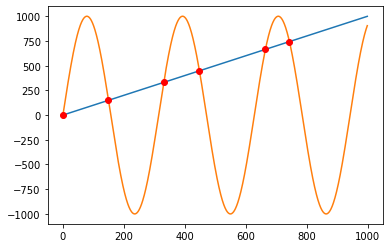

6

In [36]:
#Check how to get the no of intersections 
x = np.arange(0, 1000)
f = np.arange(0, 1000)
g = np.sin(np.arange(0, 10, 0.01) * 2) * 1000

plt.plot(x, f, '-')
plt.plot(x, g, '-')

idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
plt.plot(f[idx], f[idx], 'ro')
plt.show()
idx.shape[0]

In [0]:
#read data
data = pd.read_csv('https://gitlab.com/vsambhe1/machine-learning-competition/raw/master/test.csv')

Average Loss = 127.83: 100%|██████████| 60000/60000 [00:51<00:00, 1165.52it/s]
Finished [100%]: Average Loss = 127.84


[-1.62818667e+00  3.27117924e+00 -3.76593262e-02 -5.29164656e-04
 -1.46913855e-02  2.15634325e-02 -7.25107042e-02 -1.32318436e-02
  1.25339019e-02  6.75083582e-02 -2.67955746e-02 -1.37776697e-02
 -6.87153380e-03  7.75359184e-02]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

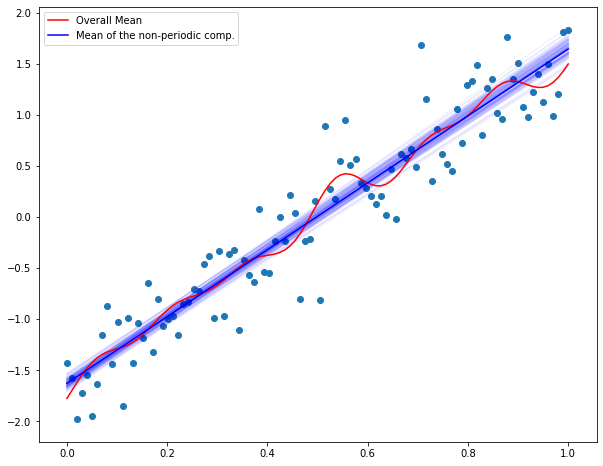

In [43]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model(X,Y,0,plot=True) 

(100, 15)


Average Loss = 135.55: 100%|██████████| 60000/60000 [00:49<00:00, 1206.34it/s]
Finished [100%]: Average Loss = 135.55


all predictions
posterior_probability_deriviative_is_positive 0.006
0
Linear predictions
posterior_probability_deriviative_is_positive 1.0
1
Periodic predictions
posterior_probability_deriviative_is_positive 0.0
0
nonlinear predictions
posterior_probability_deriviative_is_positive 0.0
0


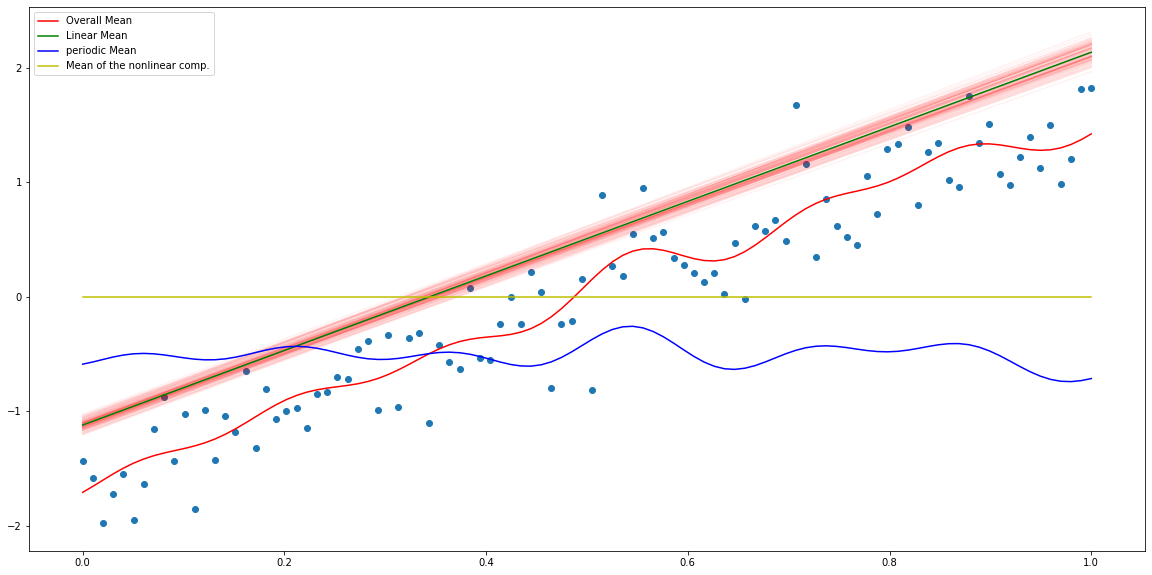

In [45]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model1(X,Y,1,plot=True)  

Average Loss = 127.87: 100%|██████████| 60000/60000 [00:50<00:00, 1189.27it/s]
Finished [100%]: Average Loss = 127.86


[-1.63060434e+00  3.26480180e+00 -4.23954136e-02 -1.93952212e-03
 -2.59160131e-02  1.98516253e-02 -6.57271921e-02 -1.41819278e-02
  1.08750475e-02  6.72455414e-02 -2.32623231e-02 -1.70705224e-02
 -1.21033880e-02  7.39699268e-02]
intersections 10
periodic - non linear to be used
posterior_probability_deriviative_is_positive 1.0


1

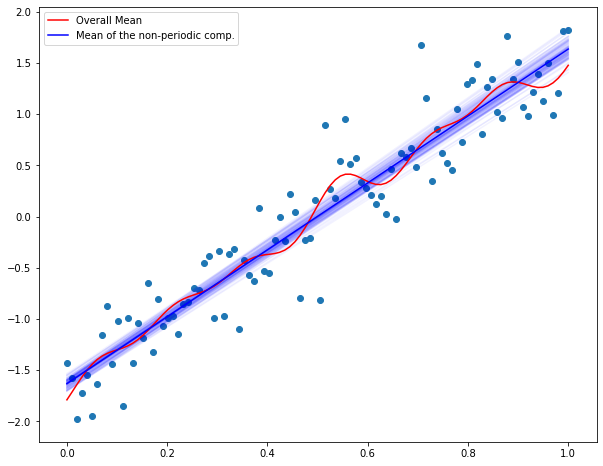

In [46]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model2(X,Y,0,plot=True)   

Average Loss = 216.64: 100%|██████████| 60000/60000 [00:50<00:00, 1188.67it/s]
Finished [100%]: Average Loss = 216.63


[-0.27979271  0.58459604 -0.27411292  0.11440457  0.05753955  0.33906723
 -0.29579231  0.01071147 -0.21857401 -0.11050505  0.32216899  0.01531078
 -0.11740116  0.12172078]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

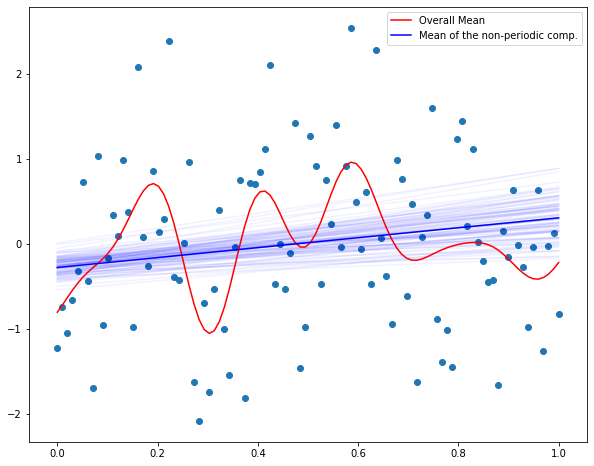

In [47]:
X = np.linspace(0,1,100)

Y = data.iloc[3,1:101].values
run_model(X,Y,0,plot=True) 

The result is right above, lets try 4th and 15th

Average Loss = 116.65: 100%|██████████| 60000/60000 [00:50<00:00, 1191.46it/s]
Finished [100%]: Average Loss = 116.64


[-1.39761244  2.77310056  0.57589164 -0.0401827  -0.30758303 -0.01763469
  0.15465627  0.00314787 -0.0094563   0.07928383  0.06257974 -0.01677909
 -0.01028139 -0.02640993]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

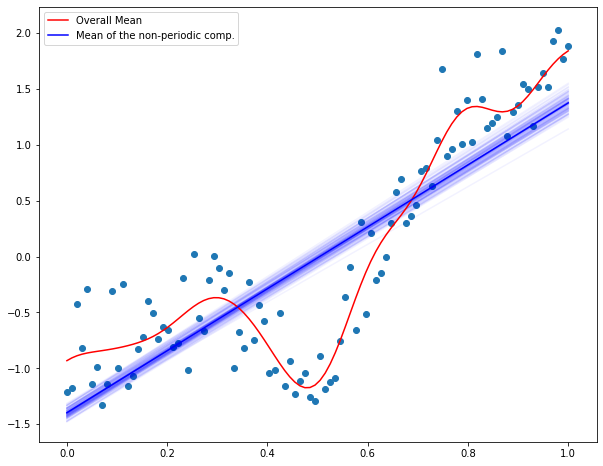

In [48]:
X = np.linspace(0,1,100)

Y = data.iloc[4,1:101].values
run_model(X,Y,0,plot=True) 

Average Loss = 222.75: 100%|██████████| 60000/60000 [00:50<00:00, 1190.53it/s]
Finished [100%]: Average Loss = 222.75


[-0.34283826  0.67956416  0.09301172 -0.11572151 -0.07453692 -0.05010322
  0.0065139  -0.00279902  0.17734955  0.05344634  0.07102613  0.00511644
  0.11600772  0.06247767]
Got one with just single or 0 intersection which is very less 
periodic - non linear to be used for gradient calculation
posterior_probability_deriviative_is_positive 1.0
1


1

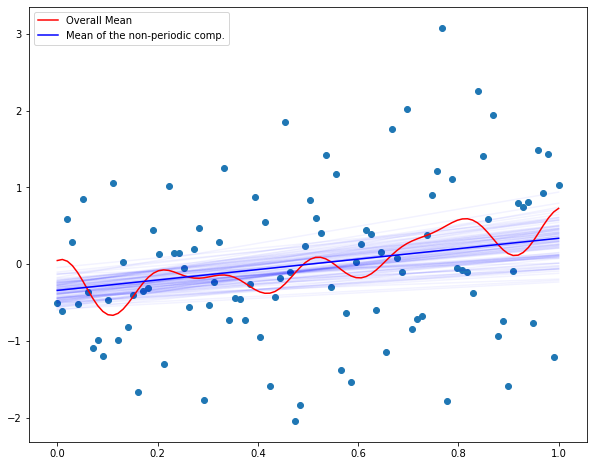

In [49]:
X = np.linspace(0,1,100)

Y = data.iloc[15,1:101].values
run_model(X,Y,0,plot=True) 

The results above are wrong